In [1]:
import os

import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import numpy as np
import tensorflow as tf
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, utils
from sklearn.metrics import classification_report, confusion_matrix

from data_utils import read_and_preprocess_data
from model_utils import *

## Settings

In [2]:
FRAME_SIZE = 128
DATA_PATH = './2sec/data_1_fps'
EPOCHS = 50

## Data

In [3]:
CLASS_COUNT, FRAME_COUNT, FRAME_SIZE, X_train, X_val, X_test, y_train, y_val, y_test = read_and_preprocess_data(DATA_PATH, FRAME_SIZE)

reading...
BalanceBeam
CricketShot
Fencing
HorseRiding
LongJump
RockClimbingIndoor
SalsaSpin
SkyDiving
TableTennisShot
WallPushups
class count = 10
med frame count = 2.0
padding...
Labels encoding...
(500,) (500, 2, 128, 128, 3)
norm...
Train-val-test split...
Train: (350, 2, 128, 128, 3) (350,)
Val: (45, 2, 128, 128, 3) (45,)
Test: (105, 2, 128, 128, 3) (105,)


## Model

In [4]:
model = models.Sequential()
model = add_2d_cnn_part(model, FRAME_COUNT, FRAME_SIZE)
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.Flatten())
model = add_dense_part(model, CLASS_COUNT)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2, 62, 62, 64)    4864      
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 2, 62, 62, 64)    248       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2, 62, 62, 64)     0         
                                                                 
 time_distributed_1 (TimeDis  (None, 2, 30, 30, 32)    32800     
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 2, 30, 30, 32)    120       
 hNormalization)                                        

In [5]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
              )


In [6]:
history = model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
11/11 [==============================] - 5s 91ms/step - loss: 2.4533 - accuracy: 0.1000 - val_loss: 2.3056 - val_accuracy: 0.0444
Epoch 2/50
11/11 [==============================] - 0s 40ms/step - loss: 2.2904 - accuracy: 0.1229 - val_loss: 2.2933 - val_accuracy: 0.0889
Epoch 3/50
11/11 [==============================] - 0s 40ms/step - loss: 2.2894 - accuracy: 0.1429 - val_loss: 2.2889 - val_accuracy: 0.0667
Epoch 4/50
11/11 [==============================] - 0s 40ms/step - loss: 2.2734 - accuracy: 0.1429 - val_loss: 2.2883 - val_accuracy: 0.0889
Epoch 5/50
11/11 [==============================] - 0s 40ms/step - loss: 2.2655 - accuracy: 0.1457 - val_loss: 2.2878 - val_accuracy: 0.0667
Epoch 6/50
11/11 [==============================] - 0s 41ms/step - loss: 2.2486 - accuracy: 0.1486 - val_loss: 2.2848 - val_accuracy: 0.1556
Epoch 7/50
11/11 [==============================] - 0s 40ms/step - loss: 2.2333 - accuracy: 0.1314 - val_loss: 2.2880 - val_accuracy: 0.1556
Epoch 8/50
11

### Train & validation Loss

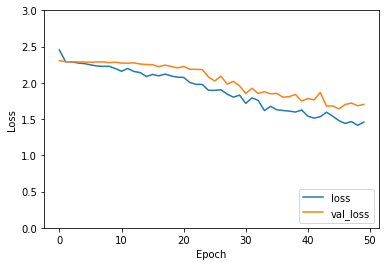

In [7]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 3])
plt.legend(loc='lower right')

### Train & validation Accuracy

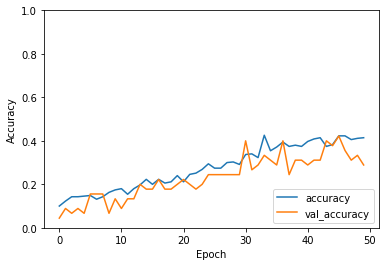

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

## Test

In [9]:
predict = np.argmax(model.predict(X_test), axis=1)

4/4 [==============================] - 0s 18ms/step


In [10]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        15
           1       0.00      0.00      0.00        16
           2       0.30      0.60      0.40         5
           3       0.32      0.78      0.45         9
           4       0.19      0.40      0.26        10
           5       1.00      0.12      0.22         8
           6       0.00      0.00      0.00        14
           7       0.37      0.70      0.48        10
           8       0.43      0.33      0.38         9
           9       0.25      0.11      0.15         9

    accuracy                           0.36       105
   macro avg       0.35      0.38      0.31       105
weighted avg       0.32      0.36      0.29       105



c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\veter\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

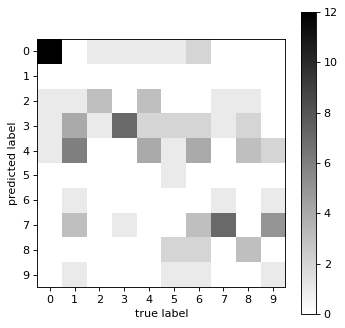

In [11]:
fig = plt.figure(figsize=(CLASS_COUNT // 2, CLASS_COUNT // 2), dpi=80)
M = confusion_matrix(predict, y_test)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(CLASS_COUNT))
plt.yticks(range(CLASS_COUNT))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass